In [9]:
# 1
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from fenics import *
from mshr import *
from ufl import nabla_grad, nabla_div, grad
from scipy.interpolate import interp2d
from abc import abstractmethod
import os
import sys
sys.path.append(os.path.realpath('../..'))

%matplotlib notebook

In [2]:
# 2
nu = 0.1
cDiff = 0.0027
dbar = 1.6925
cS = 0.5
N = 40*3 # Dimension of the grid
M = 100 # Dimension of the matrices
xmax = 1
tol = 1e-10


In [3]:
# 3
def fun(x, y, muX, muY, sigma):
    return gaussian2d(x, y, muX, muY, sigma, sigma)


def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


def gaussian2d(x, y, muX, muY, sigmaX, sigmaY):
    return 1 / (sigmaX * sigmaY * np.sqrt(2 * np.pi)) * np.exp(
        -0.5 * (((x - muX) / sigmaX) ** 2 + ((y - muY) / sigmaY) ** 2))

# N: dimension to, M: dimension from
def interpMat2(N, M, mat):
    xx = np.arange(0, 1.0, 1/(N+1))
    yy = np.arange(0, 1.0, 1/(N+1))
    x = np.arange(0, 1.0, 1/M)
    y = np.arange(0, 1.0, 1/M)
    f = interp2d(x,y,mat)
    mat = f(xx,yy)
    mat = mat.T
    mat = mat.reshape(np.prod(mat.shape))
    return mat

# r = Expression('1 + pow(2, x[0])', degree=2)
# a = Expression('0.5 * (1 - x[0]/xmax)', degree=2, xmax=xmax)
# c_k = Expression('x[0]*x[0]', degree=2)


In [4]:
# 4
x = np.arange(0, 1.0, 1 / M)
y = np.arange(0, 1.0, 1 / M)
X, Y = np.meshgrid(x, y)
zs = np.array(-fun(np.ravel(X), np.ravel(Y), 0.2, 0.5, 0.15)) * 2
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.5, 0.3, 0.1)) *0.7
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.5, 0.7, 0.1))
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.8, 0.3, 0.1)) * 0.8
zs += np.array(-fun(np.ravel(X), np.ravel(Y), 0.8, 0.7, 0.1)) * 1.1


[-0.05636114 -0.06146433 -0.06673266 ... -0.15437131 -0.12958597
 -0.10769815]
[0.99872896 0.99861387 0.99849506 ... 0.99651866 0.99707761 0.99757122]


<IPython.core.display.Javascript object>


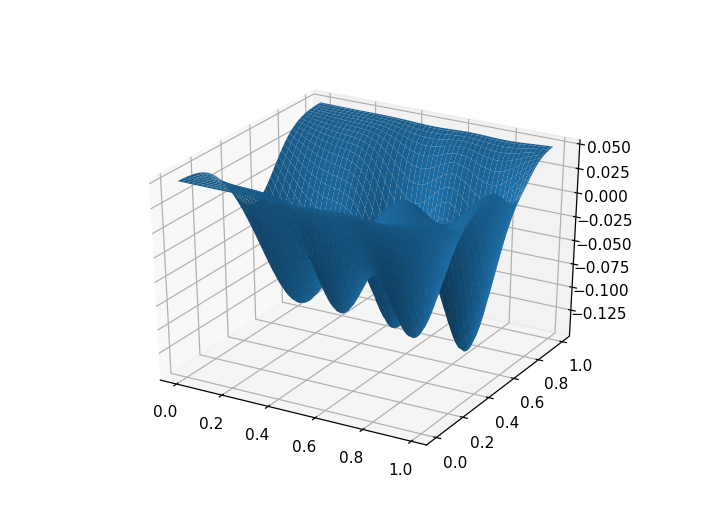

<IPython.core.display.Javascript object>


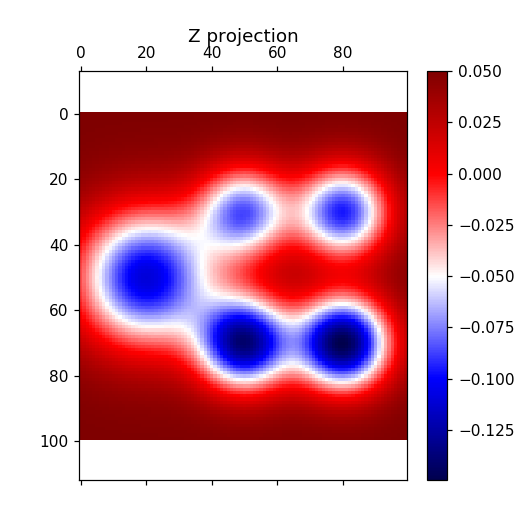

<IPython.core.display.Javascript object>


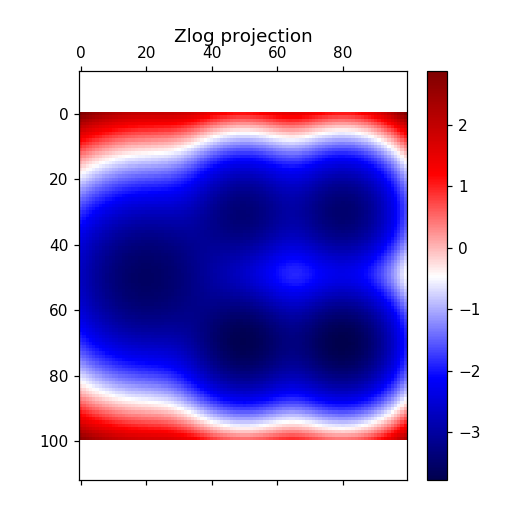

<IPython.core.display.Javascript object>


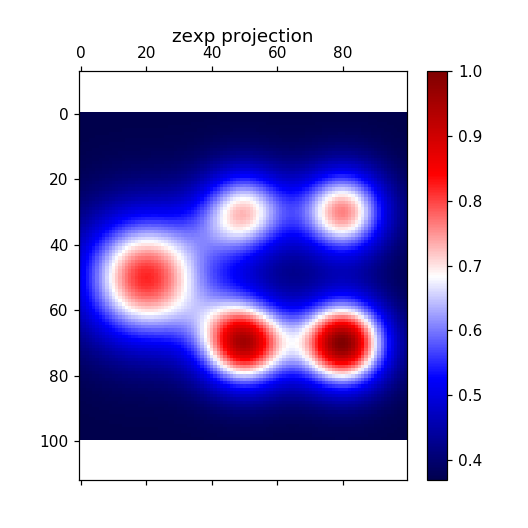

<IPython.core.display.Javascript object>


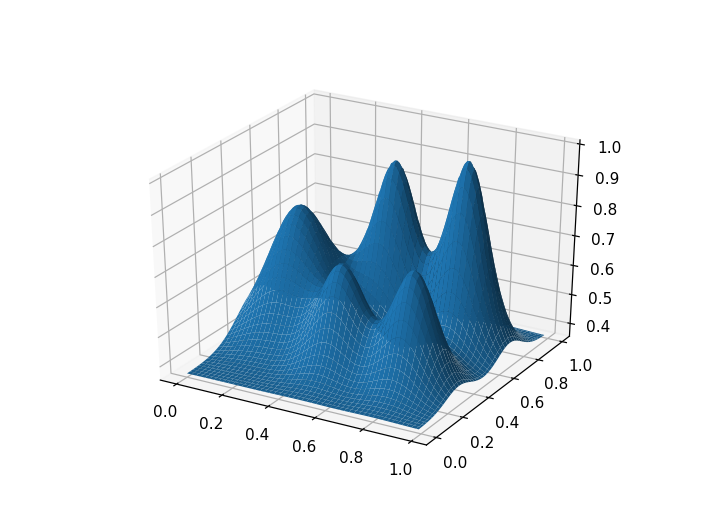

In [5]:
# 4
%matplotlib notebook
print(zs)
print((zs-min(zs))/-min(zs))
Z = (zs-max(zs))/-min(zs)
Z = Z.reshape(X.shape)*0.2
Z +=0.05
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.matshow(Z, aspect=1, cmap=plt.get_cmap('seismic'))
plt.title('Z projection')
plt.colorbar()
plt.axis('equal')
plt.show()

zlog = -np.log(np.abs(zs))
zlog = zlog.reshape(X.shape)
plt.matshow(zlog, aspect=1, cmap=plt.get_cmap('seismic'))
plt.title('Zlog projection')
plt.colorbar()
plt.axis('equal')
plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, zlog)
zexp = np.exp(-((zs-min(zs))/-min(zs)))
zexp = zexp.reshape(X.shape)
plt.matshow(zexp, aspect=1, cmap=plt.get_cmap('seismic'))
plt.title('zexp projection')
plt.colorbar()
plt.axis('equal')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, zexp)



<IPython.core.display.Javascript object>


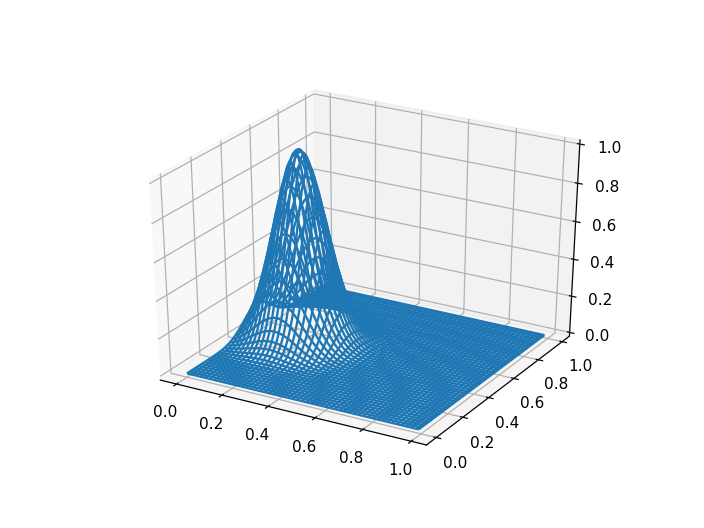

In [12]:
# 4
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(0, 1.0, 1 / M)
y = np.arange(0, 1.0, 1 / M)
X, Y = np.meshgrid(x, y)
ui = np.array(fun(np.ravel(X), np.ravel(Y), 0.2, 0.5, 0.1))
ui = (ui-min(ui))/max(ui)
Ui = ui.reshape(X.shape)
# Z2 = z2.reshape(X.shape)
# ax.plot_surface(X, Y, Ui) 
# ax.plot_surface(X, Y, Z2, linewidth=1) 
ax.plot_wireframe(X, Y, Ui) 



<IPython.core.display.Javascript object>


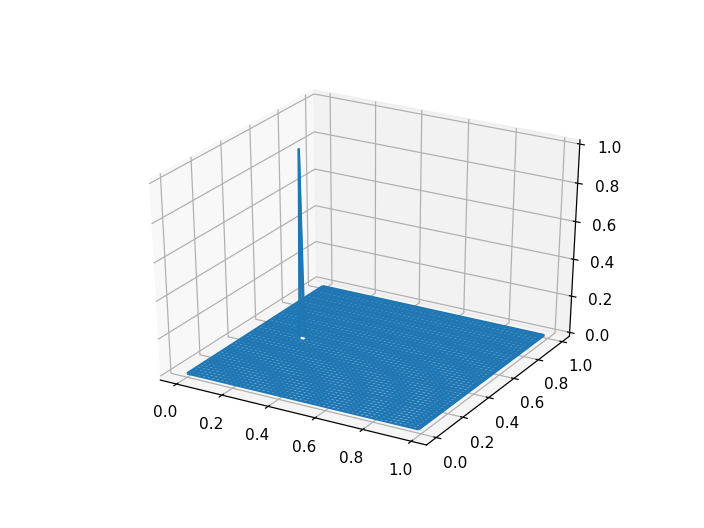

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(0, 1.0, 1 / M)
y = np.arange(0, 1.0, 1 / M)
X, Y = np.meshgrid(x, y)
ui = np.array(fun(np.ravel(X), np.ravel(Y), 0.2, 0.5, 0.005))
ui = (ui-min(ui))/max(ui)
deltaUi = ui.reshape(X.shape)
# Z2 = z2.reshape(X.shape)
# ax.plot_surface(X, Y, Ui) 
# ax.plot_surface(X, Y, Z2, linewidth=1) 
ax.plot_wireframe(X, Y, deltaUi) 



In [7]:
# 5
parameters['reorder_dofs_serial'] = False
mesh = UnitSquareMesh(N, N)  # 8X8 rectangles, each divided in 2 triangle, hence 128 cells, and 81 (9^2) vertices
Vhat = FunctionSpace(mesh, 'P', 1)  # P returns Lagrangian polynomials, 1 is the degree of the FE

## Class makeFunction(Vhat, N, M, mat): deprecated
One should use the functionFactory class instead of this one <br>
Vhat is the function space buit on the mesh<br>
N is the dimension of the mesh<br>
M is the dimension of the input matrix<br>
mat is the input matrix<br>
The function get_function returns the fencis function built from the input matrix

## Class functionFactory(Vhat, N, M)

Vhat is the function space buit on the mesh<br>
N is the dimension of the mesh<br>
M is the dimension of the input matrix<br>
The instance of the class can be directly evaluated by passing it a matrix, and the desired fenics function si returned.<br>
The function <i>plot(mat, title)</i> plots the function on the space.

In [10]:
from Dependencies.functionFactory import *

# from makeFunction import * 

<IPython.core.display.Javascript object>


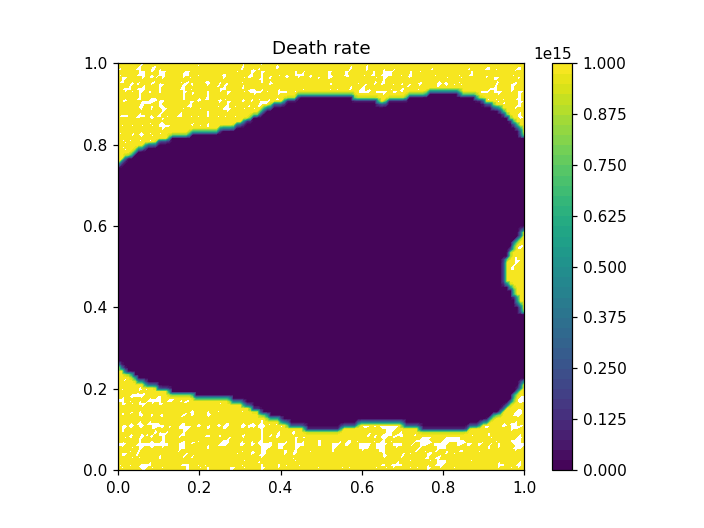

<IPython.core.display.Javascript object>


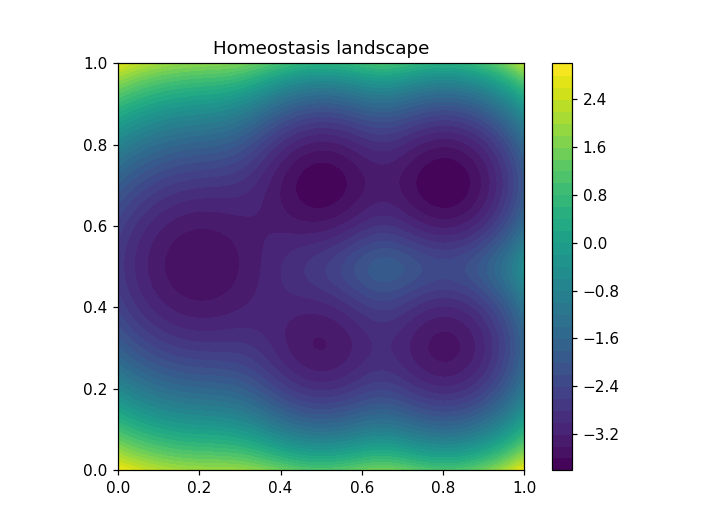

<IPython.core.display.Javascript object>


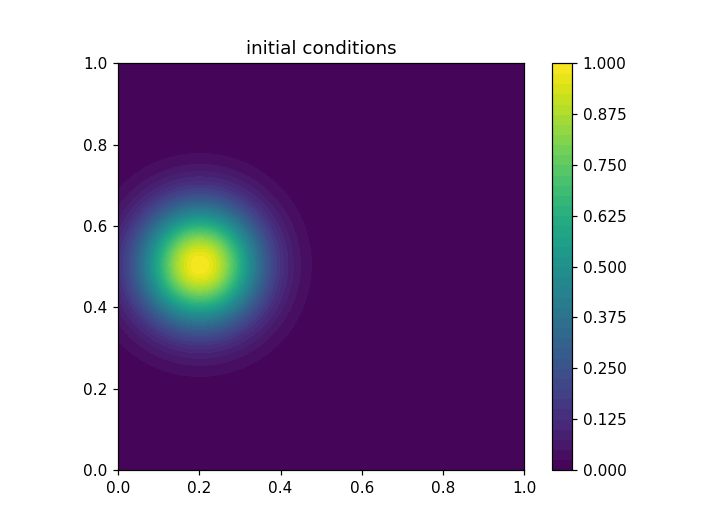

<IPython.core.display.Javascript object>


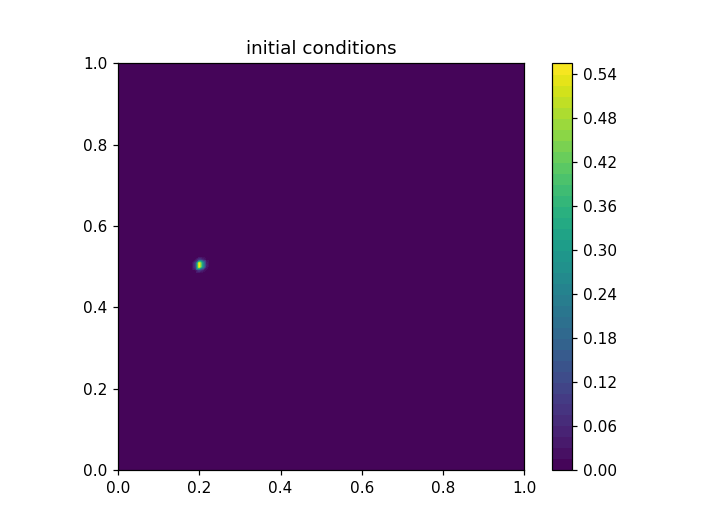

<IPython.core.display.Javascript object>


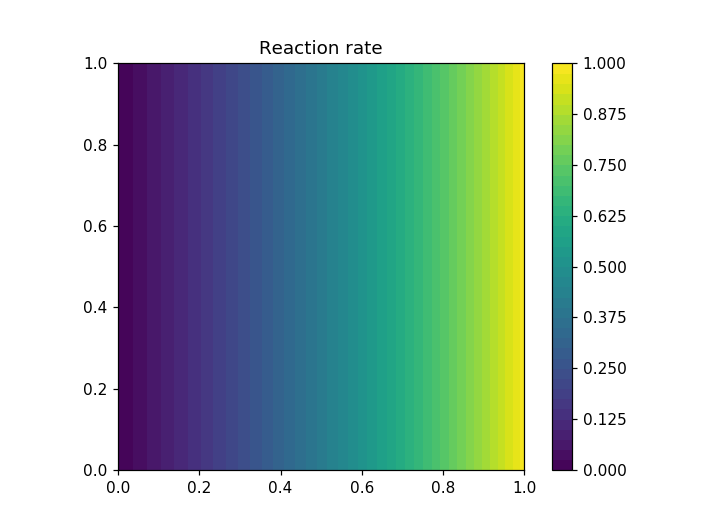

In [13]:
# 6
%matplotlib notebook

factory = functionFactory(Vhat, N, M)

uhmst = zexp.reshape(X.shape)
uhmst[uhmst<0.4]=1e-15
cDth = 1. / uhmst.T
cDthFct = factory(cDth)
factory.plot(cDth, title='Death rate')

zlog = -np.log(np.abs(zs))
zlogFct = factory(zlog)
factory.plot(zlog,title='Homeostasis landscape')


# Very basic initial conditon
UiFct = factory(0.1*Ui.T)
factory.plot(Ui.T, title='initial conditions')
deltaUiFct = factory(deltaUi.T)
factory.plot(deltaUi.T, title='initial conditions')

def rct(x_, y_):
    return -1 + 2**x_


cRctMat = np.array(rct(np.ravel(X), np.ravel(Y)))
cRctMat = cRctMat.reshape(X.shape)
cRctFct = factory(cRctMat.T)
factory.plot(cRctMat.T,title='Reaction rate')


In [14]:
# 7
def R1(u_):
    uv = u_.vector().get_local()
    cDth = cDthFct.vector().get_local()
    cRct = cRctFct.vector().get_local()
    temp = (cDth * uv)
    temp[temp > dbar] = dbar
    temp = (1 - temp)*cRct
    return temp


def v1():
    return zlogFct


def boundary(x, on_boundary):
    return on_boundary


# Differtiation rate
# Needs to be 1d --> np-ravel
def a(x_,y_):
    return 0.5*(1 - x_/max(x_))

# PT/ direction of the differentiation
def c_k_x(x_, y_):
    return x_**2

def c_k_y(x_, y_):
    return 0

<IPython.core.display.Javascript object>


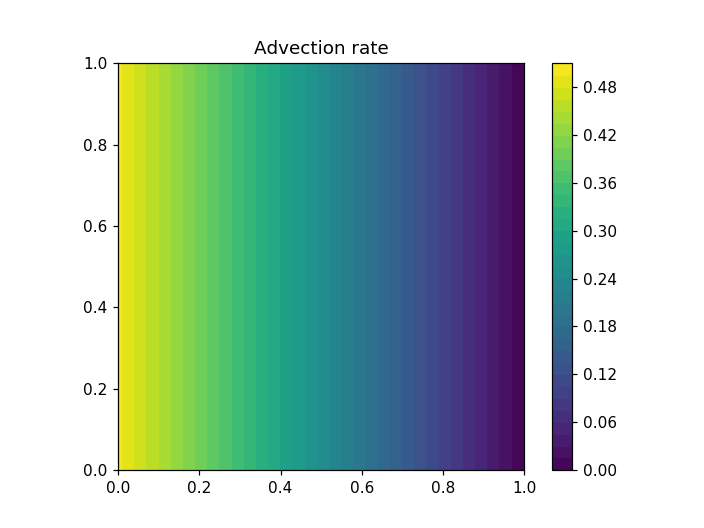

<IPython.core.display.Javascript object>


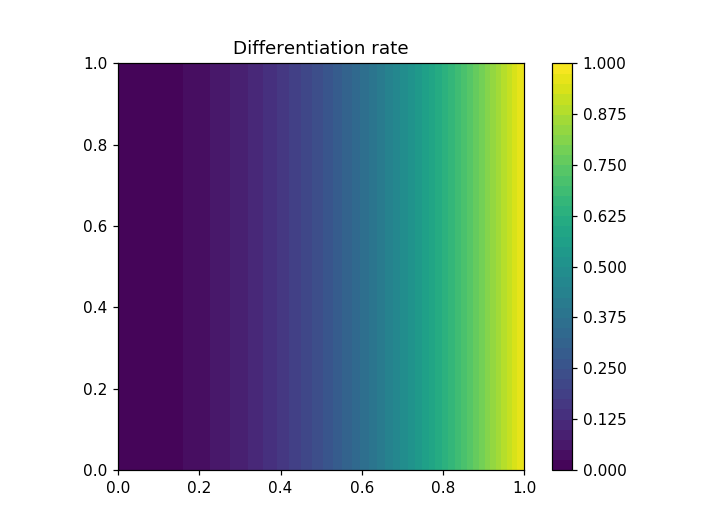

<IPython.core.display.Javascript object>


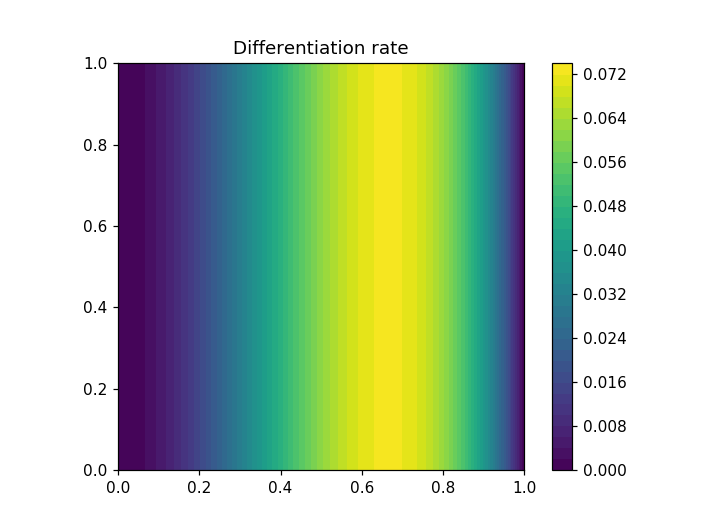

In [15]:
# 6
cAdvMat = np.array(a(np.ravel(X), np.ravel(Y)))
cAdvMat = cAdvMat.reshape(X.shape)
cAdvFct = factory(cAdvMat.T)
factory.plot(cAdvMat.T, title='Advection rate')

# !! Y component in vector space
cAMat = np.array(c_k_x(np.ravel(X), np.ravel(Y)))
cAMat = cAMat.reshape(X.shape)
cAFct = factory(cAMat.T)
factory.plot(cAMat.T, title='Differentiation rate')
factory.plot(cAMat.T*cAdvMat.T, title='Differentiation rate')

def v2(u_):
#     cAdv = cDthFct.vector().get_local()
    cAdv = cAdvFct.vector().get_local()
    cA = cAFct.vector().get_local()
    cRct = cRctFct.vector().get_local()
    return cA*(1-cAdv)*cRct

t = 1.60: difference = 0.556
t = 3.20: difference = 0.427
t = 4.80: difference = 1.87
t = 6.40: difference = 0.64
t = 8.00: difference = 0.524
t = 9.60: difference = 0.363
t = 11.20: difference = 0.209
t = 12.80: difference = 0.132
t = 14.40: difference = 0.102
t = 16.00: difference = 0.0809
t = 17.60: difference = 0.0653
t = 19.20: difference = 0.0525
t = 20.80: difference = 0.0414
t = 22.40: difference = 0.0321
t = 24.00: difference = 0.0246
t = 25.60: difference = 0.0187
t = 27.20: difference = 0.0141
t = 28.80: difference = 0.0105
t = 30.40: difference = 0.00783
t = 32.00: difference = 0.00584
t = 33.60: difference = 0.00435
t = 35.20: difference = 0.00325
t = 36.80: difference = 0.00242
t = 38.40: difference = 0.00179
t = 40.00: difference = 0.00133
t = 41.60: difference = 0.000979
t = 43.20: difference = 0.000723
t = 44.80: difference = 0.000534
t = 46.40: difference = 0.000394
t = 48.00: difference = 0.00029
t = 49.60: difference = 0.000214
t = 51.20: difference = 0.000158
t = 5

<IPython.core.display.Javascript object>


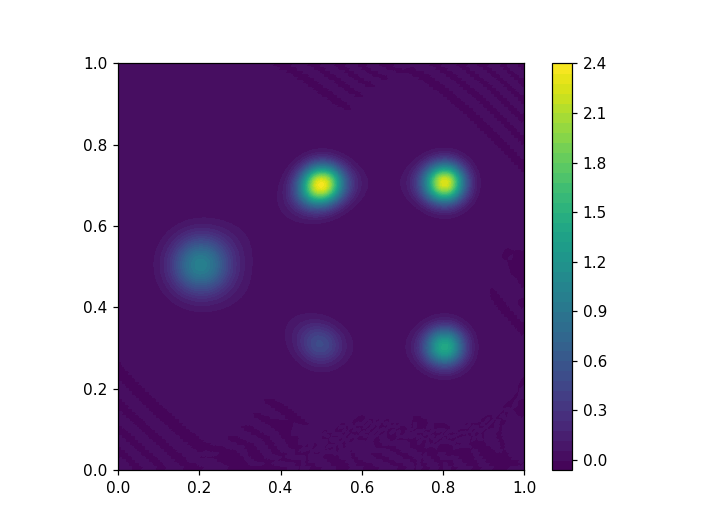

In [16]:
# 8
# %matplotlib notebook

zero = Constant(0)
bc = DirichletBC(Vhat, zero, boundary)

u = TrialFunction(Vhat)  # here it is just defined as an unknown to define a.
v = TestFunction(Vhat)
u_n = Function(Vhat)
R = Function(Vhat)
V2Fct = Function(Vhat) 

u_n = interpolate(deltaUiFct, Vhat) # initial value

# plt.figure()
# p = plot(u_n)
# plt.colorbar(p)
# plt.show()

T = 80.0  # final time
num_step = 50
dt = T / num_step
k = 1./dt
tol = 1e-6

R.vector()[:] = R1(u_n)
V2Fct.vector()[:] = v2(u_n)

F = dot((u-u_n)*k,v)*dx + nu * dot(grad(u), grad(v)) * dx + dot(nabla_grad(v1())*u, nabla_grad(v)) * dx - \
    dot( R*u, v) * dx + dot(deltaUiFct,v)*dx
#F = dot((u-u_n)*k,v)*dx + nu * dot(grad(u), grad(v)) * dx + dot(nabla_grad(v1())*u, nabla_grad(v)) * dx - \
#    dot( R*u, v) * dx - dot(V2Fct*u, nabla_grad(v)) * dx
# - dot( v2(u), grad(v)) * dx
# - dot( R(u), v) * dx
# - dot( v2(u), grad(v)) * dx
# - dot( Adv(u), grad(v)) * dx
# - dot(V2Fct*u, v.dx(0))* dx - dot(Constant(0), v.dx(1))* dx
# dot(nabla_grad(zlogFct)*u, nabla_grad(v)) * dx
# dot((u-u_n)*k,v)*dx + 

u = Function(Vhat)
a = lhs(F)
L = rhs(F)
t = 0
# u.vector()[:] = u_n.vector()[:]
# solve(a == L, u, bc)

## uncomment to save the solution onto pvd files. Can be used to plot dynamically in paraview
# vtkfile = File('framework/solution.pvd')
# vtkfile << (u_n, t)

for n in range(num_step):
    R.vector()[:] = R1(u_n)
    V2Fct.vector()[:] = v2(u_n)
    t+=dt
    solve(a == L, u, bc)
    u_e = interpolate(u_n, Vhat)
    error = np.abs(u_e.vector().get_local() - u.vector().get_local()).max()
    print('t = %.2f: difference = %.3g' % (t, error)) #relative errror
    if (error < tol):
        break
#     print(max(u.vector()))
#     print(min(u.vector()))
#     vtkfile << (u, t)
#     plt.figure()
#     p = plot(u)
#     plt.colorbar(p)
#     plt.show()
    u_n.assign(u)
    

plt.figure()
p = plot(u)
plt.colorbar(p)
plt.show()


In [18]:
from Dependencies.Bin import *

In [19]:
bin1 = Bin(0.2, 0.5, 0.1, N, '')
bin2 = Bin(0.5, 0.7, 0.1, N, '')
bin3 = Bin(0.8, 0.7, 0.1, N, '')
bin4 = Bin(0.5, 0.3, 0.1, N, '')
bin5 = Bin(0.8, 0.3, 0.1, N, '')
u1= bin1.integrate(u)
u2= bin2.integrate(u)
u3= bin3.integrate(u)
u4= bin4.integrate(u)
u5= bin5.integrate(u)
U_cont = np.array([u1,u2,u3,u4,u5])
print(U_cont)


[0.0140437  0.01864744 0.01571137 0.00411053 0.00980695]


In [20]:
R.vector()[:] = 0
V2Fct.vector()[:] = v2(u_n)
u_t = TrialFunction(Vhat)

dt = 0.00016
k = 1./dt

F = dot((u_t-u_n)*k,v)*dx + nu * dot(grad(u_t), grad(v)) * dx + dot(nabla_grad(v1())*u_t, nabla_grad(v)) * dx - \
    dot( R*u_t, v) * dx + dot(deltaUiFct,v)*dx
# t = 0
u_t = Function(Vhat)

a = lhs(F)
L = rhs(F)

solve(a == L, u_t, bc)
print((bin2.integrate(u_n-u_t))/dt)
R.vector()[:] = R1(u_n)
print(bin2.integrate(R*u_n))
g1 = (bin1.integrate(u_n-u_t)/dt) /u1
g2 = (bin2.integrate(u_n-u_t)/dt) /u2
g3 = (bin3.integrate(u_n-u_t)/dt) /u3
g4 = (bin4.integrate(u_n-u_t)/dt) /u4
g5 = (bin5.integrate(u_n-u_t)/dt) /u5
print(g1)
print(g2)
print(g3)
print(g4)
print(g5)

-0.0012207053962341242
-0.00122133377443279
0.04808958764449842
-0.06546234614328679
-0.08240024702472368
0.26396850087065055
0.02936926195565591


2.389796173814116
14641
0.0


<IPython.core.display.Javascript object>


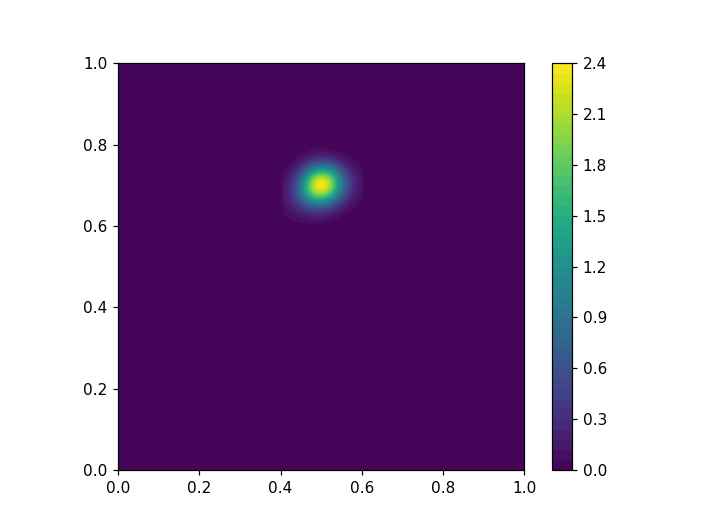

In [21]:
test = Function(Vhat)
test.assign(u)
print(u.vector()[:].max())
s = int(test.vector()[:].size)
print(s)
for n in range(0,s): 
    i = int(n /121)
    j = n % 121
#     print(i)
#     print(j)
    idx = i*121 + j
#     print(idx)
    if ((i<0.6*121 or i>0.8*121) or (j<0.4*121 or j>0.6*121)):
        test.vector()[n] = 0
#         print('set0 , ', idx)

print(test.vector()[:].min())

plt.figure()
p = plot(test)
plt.colorbar(p)
plt.show()

In [109]:
u_n.assign(test)
R.vector()[:] = 0
V2Fct.vector()[:] = v2(u_n)
u_t = TrialFunction(Vhat)
bin2 = Bin(0.5, 0.7, 0.07, N, 's')

dt = 0.00016
k = 1./dt

F = dot((u_t-u_n)*k,v)*dx + nu * dot(grad(u_t), grad(v)) * dx + dot(nabla_grad(v1())*u_t, nabla_grad(v)) * dx - \
    dot( R*u_t, v) * dx
# t = 0
u_t = Function(Vhat)

a = lhs(F)
L = rhs(F)

solve(a == L, u_t, bc)
print((bin2.integrate(u_n-u_t))/dt)
R.vector()[:] = R1(u_n)
print(bin2.integrate(R*u_n))
g1 = (bin1.integrate(u_n-u_t)/dt) /u1
g2 = (bin2.integrate(u_n-u_t)/dt) /u2
g3 = (bin3.integrate(u_n-u_t)/dt) /u3
g4 = (bin4.integrate(u_n-u_t)/dt) /u4
g5 = (bin5.integrate(u_n-u_t)/dt) /u5
# print(g1)
print(g2)
# print(g3)
# print(g4)
# print(g5)

-0.0015380319366858244
-0.0017987875391144237
-0.08247958948952319


2.389796173814116
14641
0.0


<IPython.core.display.Javascript object>


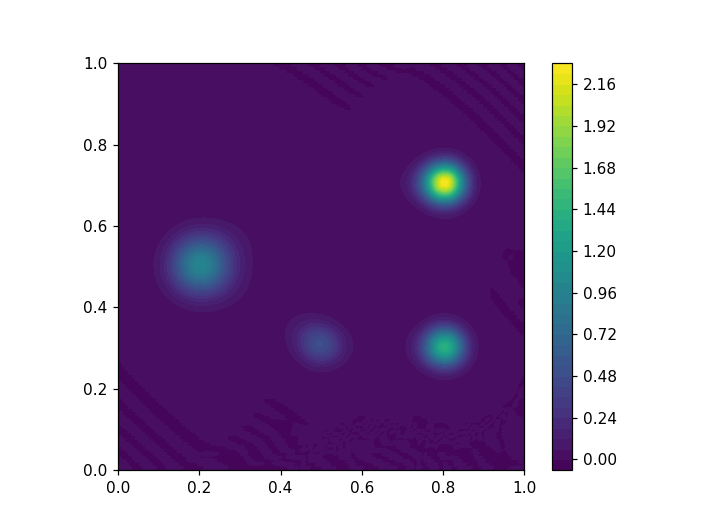

In [22]:
test2 = Function(Vhat)
test2.assign(u)
print(u.vector()[:].max())
s = int(test2.vector()[:].size)
print(s)
for n in range(0,s): 
    i = int(n /121)
    j = n % 121
#     print(i)
#     print(j)
    idx = i*121 + j
#     print(idx)
    if ((i>0.55*121 and i<0.85*121) and (j>0.35*121 and j<0.65*121)):
        test2.vector()[n] = 0
#         print('set0 , ', idx)

print(test.vector()[:].min())

plt.figure()
p = plot(test2)
plt.colorbar(p)
plt.show()

In [121]:
u_n.assign(test2)
R.vector()[:] = 0
V2Fct.vector()[:] = v2(u_n)
u_t = TrialFunction(Vhat)

dt = 0.00016
k = 1./dt

F = dot((u_t-u_n)*k,v)*dx + nu * dot(grad(u_t), grad(v)) * dx + dot(nabla_grad(v1())*u_t, nabla_grad(v)) * dx - \
    dot( R*u_t, v) * dx
# t = 0
u_t = Function(Vhat)

a = lhs(F)
L = rhs(F)

solve(a == L, u_t, bc)
print((bin2.integrate(u_n-u_t))/dt)
R.vector()[:] = R1(u_n)
print(bin2.integrate(R*u_n))
g1 = (bin1.integrate(u_n-u_t)/dt) /u1
g2 = (bin2.integrate(u_n-u_t)/dt) /u2
g3 = (bin3.integrate(u_n-u_t)/dt) /u3
g4 = (bin4.integrate(u_n-u_t)/dt) /u4
g5 = (bin5.integrate(u_n-u_t)/dt) /u5
# print(g1)
print(g2)
# print(g3)
# print(g4)
# print(g5)

-9.98528211854512e-12
0.0
-5.354778079896998e-10


2.389796173814116
14641
0.0


<IPython.core.display.Javascript object>


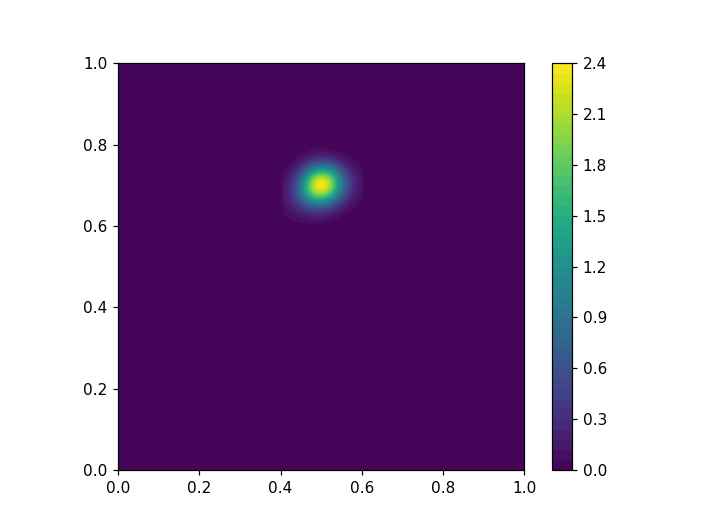

In [23]:
test.assign(u)
print(u.vector()[:].max())
s = int(test.vector()[:].size)
print(s)
for n in range(0,s): 
    i = int(n /121)
    j = n % 121
#     print(i)
#     print(j)
    idx = i*121 + j
#     print(idx)
    if ((i<0.6*121 or i>0.8*121) or (j<0.4*121 or j>0.6*121)):
        test.vector()[n] = 0
#         print('set0 , ', idx)

print(test.vector()[:].min())

plt.figure()
p = plot(test)
plt.colorbar(p)
plt.show()

In [24]:
d1= 0
d2= 0
d3= 0
d4= 0
d5= 0
r1= bin1.normedIntegral(cRctFct,u)
r2= bin2.normedIntegral(cRctFct,u)
r3= bin3.normedIntegral(cRctFct,u)
r4= bin4.normedIntegral(cRctFct,u)
r5= bin5.normedIntegral(cRctFct,u)
c12 = bin1.upperHalfOutflow(u) / bin1.outflow(u)
c14 = bin1.lowerHalfOutflow(u) / bin1.outflow(u)
c23 = 1
c45 = 1
A = np.array(
    [[r2 -g2 - d2, 0, 0, 0],
     [c23*g2, r3 -g3 - d3, 0, 0], 
     [ 0, 0, r4 -g4 - d4, 0],
     [ 0, 0, c45*g4, r5 -g5 - d5]] )

print(A)
B = np.array([-c12*g1,0, -c14*g1,0])*u1
print(B)
Y = np.linalg.solve(A,B)
u_dis=np.array([u1,Y[0],Y[1],Y[2],Y[3]])
print(u_dis)
print(np.array(U_cont))
print((u_dis - U_cont)/u1)
print(sum(u_dis - U_cont)/u1)

[[ 0.47574563  0.          0.          0.        ]
 [-0.06546235  0.81700964  0.          0.        ]
 [ 0.          0.          0.14173825  0.        ]
 [ 0.          0.          0.2639685   0.70565391]]
[-0.00037205  0.         -0.0003033   0.        ]
[ 1.40437013e-02 -7.82037345e-04 -6.26602144e-05 -2.13989487e-03
  8.00484253e-04]
[0.0140437  0.01864744 0.01571137 0.00411053 0.00980695]
[ 0.         -1.38350143 -1.12321025 -0.44506989 -0.64131708]
-3.5930986514781496


In [ ]:
R.vector()[:] = R1(u)
# r1= bin1.normedIntegral(R,u)
# r2= bin2.normedIntegral(R,u)
# r3= bin3.normedIntegral(R,u)
# r4= bin4.normedIntegral(R,u)
# r5= bin5.normedIntegral(R,u)
d1= 0
d2= 0
d3= 0
d4= 0
d5= 0
r1= bin1.normedIntegral(cRctFct,u)
r2= bin2.normedIntegral(cRctFct,u)
r3= bin3.normedIntegral(cRctFct,u)
r4= bin4.normedIntegral(cRctFct,u)
r5= bin5.normedIntegral(cRctFct,u)

A = np.array(
    [[(r1 - g1 - d1), 0, 0, 0, 0],
     [c12*g1, r2 - g2 - d2, 0, 0, 0],
     [0, c23*g2, r3 - g3 - d3, 0, 0], 
     [c14*g1, 0, 0, r4 - g4 - d4, 0],
     [0, 0, 0, c45*g4, r5 - g5 - d5]] )
print(A)

def pend(y, t):
    d1= r1*(min(y[0]/u1,dbar))
    d2= r2*(min(y[1]/u2,dbar))
    d3= r3*(min(y[2]/u3,dbar))
    d4= r4*(min(y[3]/u4,dbar))
    d5= r5*(min(y[4]/u5,dbar))
    dydt = np.zeros((5))
    dydt[0] = (r1 - g1 - d1)* y[0]
    dydt[1] = c12*g1*y[0] + (r2 -g2 - d2)*y[1]
    dydt[2] = c23*g2*y[1] + (r3 -g3 - d3)*y[2]
    dydt[3] = c14*g1*y[0] + ( r4 -g4 - d4)*y[3]
    dydt[4] = c45*g4*y[3] + (r5 -g5 - d5)*y[4]
    return dydt

# print(A)
t = np.linspace(0, 400, 10)
ui = np.array(U_cont)*0.5
print(np.array(odeint(pend, ui, t)))
print(np.array(U_cont))

<IPython.core.display.Javascript object>


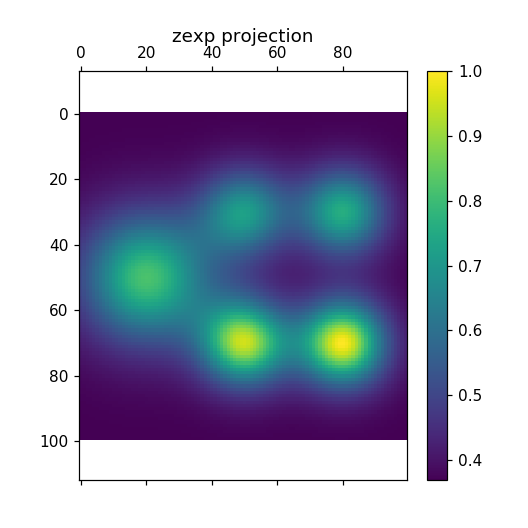

(100, 100)
(14641,)


<IPython.core.display.Javascript object>


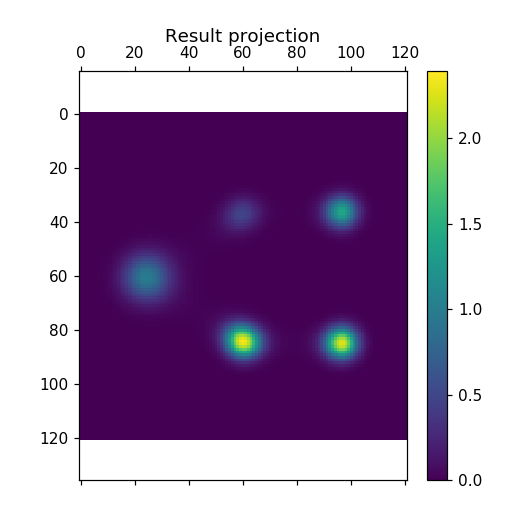

In [30]:
zexp = np.exp(-((zs-min(zs))/-min(zs)))
zexp = zexp.reshape(X.shape)
plt.matshow(zexp, aspect=1, cmap=plt.get_cmap('viridis'))
plt.title('zexp projection')
plt.colorbar()
plt.axis('equal')
plt.show()
print(Z.shape)
zFct = factory(Z)
# factory.plot(Z.T, title='ZFct')

Res= u.vector()[:]

print(Res.shape)
Res = Res.reshape((121,121))
plt.matshow(Res, aspect=1, cmap=plt.get_cmap('viridis'))
plt.title('Result projection')
plt.colorbar()
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


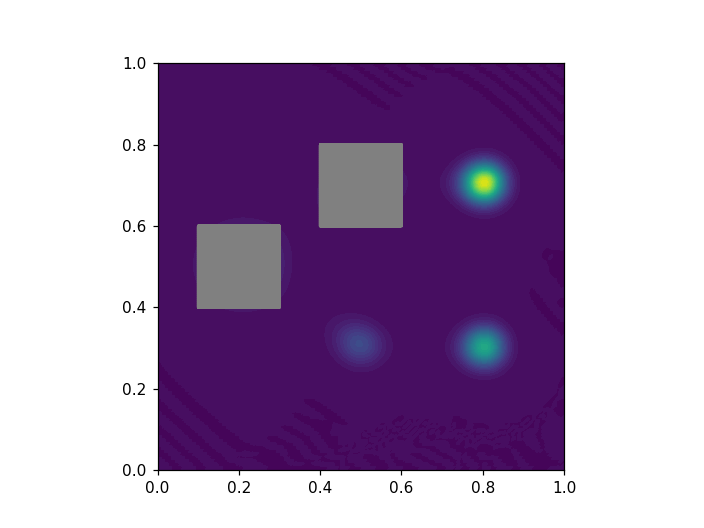

0.014043701291196526
0.01864744342590765


In [26]:
plt.figure()
plot(u)
bin1 = Bin(0.2, 0.5, 0.1, N, '')
bin2 = Bin(0.5, 0.7, 0.1, N, '')
print(bin1.integrate(u))
print(bin2.integrate(u))
plot(bin1.mesh)
plot(bin2.mesh)

<IPython.core.display.Javascript object>


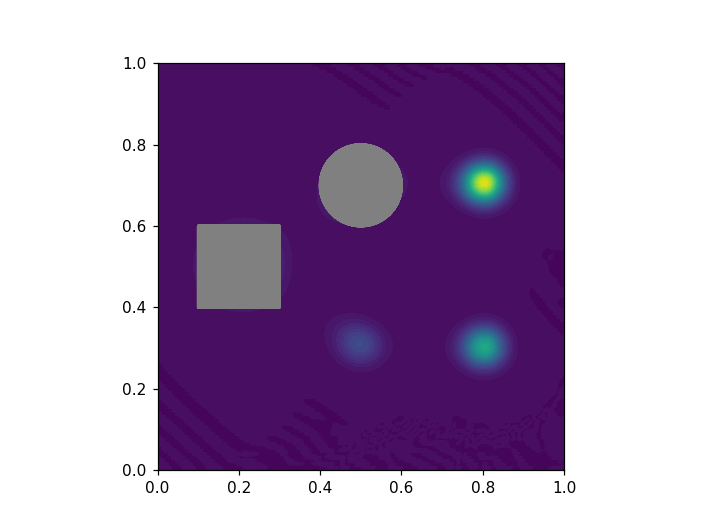

0.014043701291196526
0.018399406731034438


In [27]:
# 9
# Example of the definitions of several bins, and plotting of their respective mesh on the last generated figure
plt.figure()
plot(u)
bin1 = Bin(0.2, 0.5, 0.1, N, '')
print(bin1.integrate(u))
plot(bin1.mesh)
bin2 = Bin(0.5, 0.7, 0.1, N, 'c')
print(bin2.integrate(u))
plot(bin2.mesh)
# plt.show()
bin2.setState('s')
# plot(bin2.getMesh())
# plt.show()

In [28]:
bin1 = Bin(0.2, 0.5, 0.1, N, '')
bin2 = Bin(0.5, 0.7, 0.1, N, '')
bin3 = Bin(0.8, 0.7, 0.1, N, '')
bin4 = Bin(0.5, 0.3, 0.1, N, '')
bin5 = Bin(0.8, 0.3, 0.1, N, '')

In [29]:
u1= bin1.integrate(u)
u2= bin2.integrate(u)
u3= bin3.integrate(u)
u4= bin4.integrate(u)
u5= bin5.integrate(u)
U_cont = np.array([u1,u2,u3,u4,u5])
print(U_cont)

z1= bin1.integrate(zFct)
z2= bin2.integrate(zFct)
z3= bin3.integrate(zFct)
z4= bin4.integrate(zFct)
z5= bin5.integrate(zFct)
zFct_cont = np.array([z1,z2,z3,z4,z5])
print(zFct_cont)

[0.0140437  0.01864744 0.01571137 0.00411053 0.00980695]
[-8.04423823e-04 -7.52245843e-05 -1.80730322e-03 -3.06269858e-03
  2.77434970e-04]


In [75]:
print(-zFct_cont)

[ 8.04423823e-04  7.52245843e-05  1.80730322e-03  3.06269858e-03
 -2.77434970e-04]


In [69]:
a= np.array([0.011790659921271797, 0.015641238166167557, 0.01689382710057417, 0.0033236898144488394, 0.010407136955939355])
b= np.array([0.014649483218640092, 0.018949447356993773, 0.015784867123448315, 0.004181671598561665, 0.009824349466437602])
print((b-a)/u1)

[ 0.19514841  0.22582429 -0.0756996   0.05856738 -0.03978212]


In [19]:
r1= bin1.normedIntegral(cRctFct,u)
r2= bin2.normedIntegral(cRctFct,u)
r3= bin3.normedIntegral(cRctFct,u)
r4= bin4.normedIntegral(cRctFct,u)
r5= bin5.normedIntegral(cRctFct,u)

In [63]:
R.vector()[:] = R1(u)
r1= bin1.normedIntegral(R,u)
r2= bin2.normedIntegral(R,u)
r3= bin3.normedIntegral(R,u)
r4= bin4.normedIntegral(R,u)
r5= bin5.normedIntegral(R,u)
d1= 0
d2= 0
d3= 0
d4= 0
d5= 0

In [21]:
c12 = bin1.upperHalfOutflow(u) / bin1.outflow(u)
c14 = bin1.lowerHalfOutflow(u) / bin1.outflow(u)
c23 = 1
c45 = 1


In [22]:
from scipy.integrate import odeint

In [23]:
print(r1)
print(r1*(min(0.0111597/u1,dbar)))
print(g1)
print(r1-g1-r1*(min(0.0111597/u1,dbar)))

0.060188901005024276
0.06018888780829597


NameError: name 'g1' is not defined

In [137]:
# perturbed discrete system
R.vector()[:] = R1(u)
# r1= bin1.normedIntegral(R,u)
# r2= bin2.normedIntegral(R,u)
# r3= bin3.normedIntegral(R,u)
# r4= bin4.normedIntegral(R,u)
# r5= bin5.normedIntegral(R,u)
# d1= 0
# d2= 0
# d3= 0
# d4= 0
# d5= 0
r1= bin1.normedIntegral(cRctFct,u)
r2= bin2.normedIntegral(cRctFct,u)
r3= bin3.normedIntegral(cRctFct,u)
r4= bin4.normedIntegral(cRctFct,u)
r5= bin5.normedIntegral(cRctFct,u)

A = np.array(
    [[(r1 - g1 - d1), 0, 0, 0, 0],
     [c12*g1, r2 - g2 - d2, 0, 0, 0],
     [0, c23*g2, r3 - g3 - d3, 0, 0], 
     [c14*g1, 0, 0, r4 - g4 - d4, 0],
     [0, 0, 0, c45*g4, r5 - g5 - d5]] )
print(A)

def pend(y, t):
    d1= r1*(min(y[0]/u1,dbar))
    d2= r2*(min(y[1]/u2,dbar))
    d3= r3*(min(y[2]/u3,dbar))
    d4= r4*(min(y[3]/u4,dbar))
    d5= r5*(min(y[4]/u5,dbar))
    dydt = np.zeros((5))
    dydt[0] = (r1 - g1 - d1)* y[0]
    dydt[1] = c12*g1*y[0] + (r2 -g2 - d2)*y[1]
    dydt[2] = c23*g2*y[1] + (r3 -g3 - d3)*y[2]
    dydt[3] = c14*g1*y[0] + ( r4 -g4 - d4)*y[3]
    dydt[4] = c45*g4*y[3] + (r5 -g5 - d5)*y[4]
    return dydt

# print(A)
t = np.linspace(0, 400, 10)
ui = np.array(U_cont)*0.5
print(np.array(odeint(pend, ui, t)))
print(np.array(U_cont))

[[ 0.09052313  0.          0.          0.          0.        ]
 [ 0.03330284  0.43066426  0.          0.          0.        ]
 [ 0.         -0.01941641  0.85633433  0.          0.        ]
 [ 0.02714002  0.          0.          0.11464818  0.        ]
 [ 0.          0.          0.          0.29198961  0.74409556]]
[[0.00557985 0.00782062 0.00844691 0.00166184 0.00520357]
 [0.00666787 0.01687962 0.01914702 0.00177108 0.01110653]
 [0.00669123 0.01688175 0.01914696 0.00177385 0.01110762]
 [0.00669164 0.01688178 0.01914696 0.0017739  0.01110764]
 [0.00669165 0.01688178 0.01914696 0.0017739  0.01110764]
 [0.00669164 0.01688178 0.01914696 0.0017739  0.01110764]
 [0.00669165 0.01688178 0.01914696 0.0017739  0.01110764]
 [0.00669165 0.01688178 0.01914696 0.0017739  0.01110764]
 [0.00669165 0.01688178 0.01914696 0.0017739  0.01110764]
 [0.00669165 0.01688178 0.01914696 0.0017739  0.01110764]]
[0.0111597  0.01564124 0.01689383 0.00332369 0.01040714]


In [81]:
A = np.array(
    [[r2 -g2 - d2, 0, 0, 0],
     [c23*g2, r3 -g3 - d3, 0, 0], 
     [ 0, 0, r4 -g4 - d4, 0],
     [ 0, 0, c45*g4, r5 -g5 - d5]] )

print(A)
B = np.array([-c12*g1,0, -c14*g1,0])*u1
print(B)
Y = np.linalg.solve(A,B)
u_dis=np.array([u1,Y[0],Y[1],Y[2],Y[3]])
print(u_dis)
print(np.array(U_cont))
print((u_dis - U_cont)/u1)
print(sum(u_dis - U_cont)/u1)

[[ -91.21836025    0.            0.            0.        ]
 [  90.48555393  -70.48049399    0.            0.        ]
 [   0.            0.         -115.39164315    0.        ]
 [   0.            0.          114.33925885  -69.63040134]]
[-1.03272824  0.         -0.84161786  0.        ]
[0.01179066 0.0113215  0.01453497 0.00729358 0.0119767 ]
[0.01179066 0.01564124 0.01689383 0.00332369 0.01040714]
[ 0.         -0.3663699  -0.20006161  0.33669764  0.13311892]
-0.09661494313284948
